In [7]:
from nn_mri import ImageFitting_set, SineLayer, get_mgrid, calculate_contrast, save_dicom
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray, gray2rgb
from torch import nn
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as sio
import os
import argparse
from csv import writer

In [9]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, 
                 hidden_layers, out_features, 
                 first_omega_0=30., 
                 hidden_omega_0=30.,
                 perturb=False):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))
        self.relu = nn.ReLU()
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
        self.net.append(nn.Linear(hidden_features, hidden_features))
        self.net.append(nn.ReLU())
        self.final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        #self.net.append(final_linear)
        self.net = nn.Sequential(*self.net)
        self.perturb_linear = nn.Linear(3, hidden_features)
        self.perturb_linear2 = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.perturb_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
            self.perturb_linear2.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.tanh = nn.Tanh()  
        self.perturb = perturb
    def forward(self, coords, sample=0,eps=0):
        coords = coords.clone().detach().requires_grad_(False) # allows to take derivative w.r.t. input
        if self.perturb:
            acq = torch.tensor([sample], dtype=torch.float).cuda()
            acq = acq.repeat(coords.size(0),1)
            perturbation = self.perturb_linear(torch.cat((model_input, acq),-1))
            perturbation = self.tanh(perturbation)
            perturbation = self.perturb_linear2(perturbation)
            pertubation = eps*self.tanh(perturbation)
            coords = coords + pertubation
        output = self.net(coords)
        output = self.final_linear(output)
        output = self.relu(output)
        return output

In [10]:
eps = 1e-7
mag = 1000

def calc_adc(dwi, b0, b):
    adc = -np.log((dwi/(b0 + eps)) + eps)/b 
    return adc*mag

In [12]:
def calculate_CNR_SNR(case, image):
    """ calculates the CNR and SNR based on cancer and the collateral benign tissue"""
    # cancer center x,y locations
    cc_x, cc_y = case.cancer_loc
    # contralateral benign x,y locations
    cb_x, cb_y = case.contralateral_loc
    # noise x,y locations
    cn_x, cn_y = case.noise
    cancer_area = image[cc_x - 1 : cc_x + 2, cc_y - 1 : cc_y + 2]
    contralateral_area = image[cb_x - 1 : cb_x + 2, cb_y - 1 : cb_y + 2]
    noise_area = image[cn_x - 2 : cn_x + 3, cn_y - 2 : cn_y + 3]
    
    #cancer_mean
    Sc = cancer_area.mean()
    #begign_mean
    Sb = contralateral_area.mean()
    #noise variance
    N = np.std(noise_area)
    
    SNRc = Sc/(N+1e-7)
    SNRb = Sb/(N+1e-7)
    CNR = abs(SNRc - SNRb)
    return np.log10(SNRc), np.log10(CNR), Sc, Sb, N

In [ ]:
def calc_adc_erd_single2(_case, mul=1000, slope=20):
    eps = 1e-7
    def onehot(x):
        _max = np.argmax(x)
        a = np.zeros_like(x)
        a[_max] = 1
        return a
    def calc_mean_adc(Sb, S0, bval):
        adc = np.zeros((S0.shape))        
        adc = -np.log(Sb/(S0 + eps) + eps)/(bval)
        return adc*1000
    mean_image = np.zeros((_case.b0.shape))
    noise_center = _case.noise
    _slice = _case.cancer_slice
    noise_level = np.std(_case.b3[noise_center[0]-3:noise_center[0]+2, 
                                  noise_center[1]-3:noise_center[1]+2,
                                  _slice])/np.sqrt(2-np.pi/2)
    for i in range(_case.b0.shape[0]):
        for j in range(_case.b0.shape[1]):
            x = _case.b3[i, j, _slice, :]
            b_zero = _case.b0[i,j,_slice]
            if np.mean(x)>2*noise_level:
                temp = max(mul*np.exp(-slope*(np.mean(x)/b_zero)), 2)
                try:
                    a = np.exp(x/temp)/np.sum(np.exp(x/temp))
                except RuntimeWarning:
                    a = onehot(x)
                    print('here')
                    
                y = np.sum(a*x)
                mean_image[i,j, _slice] = y
            else:
                mean_image[i,j, _slice] = np.mean(x)

    return calc_mean_adc(mean_image, _case.b0, _case.b[3])

In [8]:
class case:
    def __init__(self, pt_id, erc, cancer_loc, contralateral_loc, noise, cancer_slice):
        '''
        class for a case
        pt_id : the patient id
        cancer_loc : cancer location pixel (center of a 3x3 region)
        contralateral_loc : mirror of the cancer location with is non-cancer
        cancer_slice : slice number where the cancer exists
        acquisitions : number of slices per X, Y, Z directions 
        '''
        
        self.pt_id = pt_id
        self.cancer_loc = cancer_loc
        self.contralateral_loc = contralateral_loc
        self.noise = noise
        self.cancer_slice = cancer_slice
        if erc:
            self.b = (0, 150, 1000, 1500)
        else:
            self.b = (0, 300, 600, 900)
        pt_no = self.pt_id.split('-')[-1]
        file_address = '/scratch/midway3/gundogdu/RECONSTRUCTION'
        filename = os.path.join(file_address, pt_no, 'no_aver', 'bigImage.mat')
        self.b0 = sio.loadmat(filename)['b0']
        self.b1 = sio.loadmat(filename)['b1']
        self.b2 = sio.loadmat(filename)['b2']
        self.b3 = sio.loadmat(filename)['b3']

                         
cases = []

cases.append(case('18-1681-07', 0, (67, 73), (63, 57), (80,65), 11))
cases.append(case('18-1681-08', 0, (80, 74), (77, 54), (97,65), 10))
cases.append(case('18-1681-09', 0, (62, 64), (56, 70), (76,62), 15))
cases.append(case('18-1681-30', 0, (67, 54), (66, 78), (84,64), 17))
cases.append(case('18-1681-37', 0, (68, 76), (71, 59), (80,67), 10))
cases.append(case('phantom-water', 0, (64, 64), (64, 64), (64,64), 13))
cases.append(case('17-1694-82', 1, (56, 52), (56, 74), (80,60), 16))
cases.append(case('18-1681-41', 1, (69, 57), (69, 69), (86,65), 8))
cases.append(case('18-1694-76', 1, (73, 69), (73, 52), (90,64), 16))
cases.append(case('18-1681-45', 1, (71, 68), (65, 74), (87,62), 13))
cases.append(case('18-1694-78', 1, (62, 76), (63, 53), (78,60), 20))

In [38]:
case = cases[0]
_slice = case.cancer_slice
b = case.b[3]
b0 = case.b0[:, :, _slice]
dwi = case.b3[:, :, _slice, :]
inx = np.arange(case.b3.shape[3])

img = np.mean(dwi,-1)
img_dataset = [Image.fromarray(img)]
dataset = ImageFitting_set(img_dataset)
transform = Compose([ToTensor()])
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3)
img_siren.cuda()
torch.cuda.empty_cache()
optim = torch.optim.Adam(lr=0.00004, params=img_siren.parameters())
noise_range = case.b3[case.noise[0]-2:case.noise[0]+3, case.noise[1]-2:case.noise[1]+3, _slice,:].max()

In [39]:
ctr = 1
_loss = 1000
print('pre-training IRN')
while(_loss > 0.00002):
    ground_truth, model_input  = dataset.pixels[0], dataset.coords[0]
    ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
    model_output = img_siren(model_input)
    loss = (model_output - ground_truth)**2
    loss = loss.mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    _loss = loss.item()
    ctr +=1
    if not model_output.cpu().detach().numpy().max():
        img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3)
        img_siren.cuda()
        torch.cuda.empty_cache()
        optim = torch.optim.Adam(lr=0.00004, params=img_siren.parameters())
        print('restarting model')
    if not (ctr%1000):
        print(f'{ctr}')

PATH = case.pt_id + '.pt'
torch.save(img_siren.state_dict(), PATH)

pre-training IRN
1000
2000
3000
4000
5000


In [40]:
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=True)

PATH = case.pt_id + '.pt'
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

Siren(
  (relu): ReLU()
  (final_linear): Linear(in_features=128, out_features=1, bias=True)
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (perturb_linear): Linear(in_features=3, out_features=128, bias=True)
  (perturb_linear2): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
)

In [41]:
accept = np.zeros((case.b3.shape))
dwi_copy = case.b3.copy()
print('Conducting Auto-ERD with Agglomerative Clustering...')
for i in range(case.b3.shape[0]):
    for j in range(case.b3.shape[1]):
        acq = case.b3[i, j, _slice, :].reshape(-1,1)
        db = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(acq)
        sample_means = [acq[db.labels_== x].mean() for x in set(db.labels_)]
        sample_lens = [len(acq[db.labels_== x]) for x in set(db.labels_)]
        if (sample_lens[0] > sample_lens[1]):# > noise_range and (sample_lens[0]>=case.dwi.shape[3]/3):
            accept[i, j, _slice, inx[db.labels_== 0]] = 1#sample_lens[0]/sample_lens[1]
        elif (sample_lens[1] > sample_lens[0]):# > noise_range and (sample_lens[1]>=case.dwi.shape[3]/3):
            accept[i, j, _slice, inx[db.labels_== 1]] = 1#sample_lens[1]/sample_lens[0]
        else:
            accept[i, j, _slice, :] = 1

Conducting Auto-ERD with Agglomerative Clustering...


In [42]:
accept_weights = []
img_dataset = []
for acq in range(case.b3.shape[3]):
    _accept = accept[:, :, _slice, acq]
    img = dwi_copy[:, :, _slice, acq]    
    accept_weights.append(_accept)
    img_dataset.append(Image.fromarray(img))
dataset = ImageFitting_set(img_dataset)
_accept_weights = torch.empty((len(img_dataset), dataset.shape[0]**2, 1))
for ctr, accept in enumerate(accept_weights):
    transform = Compose([ToTensor()])
    accept = transform(accept)
    _accept_weights [ctr] = accept.permute(1, 2, 0).view(-1, 1)

In [43]:
params1 = list(img_siren.perturb_linear.parameters()) + list(img_siren.perturb_linear2.parameters())
optim1 = torch.optim.Adam(lr=0.01, params=params1)
params2 = list(img_siren.net.parameters()) + list(img_siren.final_linear.parameters())
optim2 = torch.optim.Adam(lr=0.0000001, params=params2)
ctr = 0
new_loss = 1000
img = np.mean(dwi,-1)

print('b', [round(x,4) for x in calculate_CNR_SNR(case, np.mean(dwi,-1))])
model_input  = dataset.coords[0].cuda()
model_output = img_siren(model_input)
print('b2', [round(x,4) for x in calculate_CNR_SNR(case, model_output.cpu().view(128,128).detach().numpy())])
while True:
    mean_recon = np.zeros((128,128))
    for sample in range(case.b3.shape[3]):
        ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        model_output = img_siren(model_input, sample=sample, eps=1.0/128.0)
        mean_recon += model_output.cpu().view(128,128).detach().numpy()
        #(_accept_weights[sample].cuda()*
        if not sample:
            loss = (_accept_weights[sample].cuda()*(model_output - ground_truth)**2).mean()
        else:
            loss += (_accept_weights[sample].cuda()*(model_output - ground_truth)**2).mean()
    mean_recon /= case.b3.shape[3]
    optim1.zero_grad()
    optim2.zero_grad()
    loss.backward()
    optim1.step()
    optim2.step()
    if loss.item() > new_loss and ctr>100:
        break      
    else:
        new_loss = loss.item()
    if not ctr%100:
        model_output = img_siren(model_input)
        print(ctr, [round(x,4) for x in calculate_CNR_SNR(case, mean_recon)])
    ctr +=1

b [1.3407, 0.6571, 7.0691, 5.6044, 0.3226]
b2 [1.3407, 0.6565, 7.0671, 5.6048, 0.3225]
0 [1.3419, 0.6583, 7.0665, 5.6022, 0.3216]
100 [1.3436, 0.6642, 7.0465, 5.5724, 0.3194]
200 [1.3429, 0.6666, 7.0291, 5.548, 0.3192]
300 [1.3378, 0.6632, 7.0162, 5.5321, 0.3223]


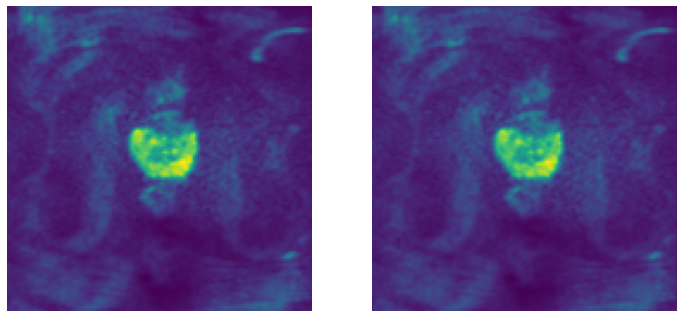

[1.341, 0.657, 7.069, 5.604, 0.323]
[1.339, 0.665, 7.01, 5.523, 0.322]


In [44]:
mean_recon = np.zeros((128,128))
model_input  = dataset.coords[0].cuda()
for i in range(case.b3.shape[3]):
    model_output = img_siren(model_input, i, 1.0/128.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= case.b3.shape[3]
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(mean_recon)
axes[1].imshow(img)
axes[0].axis('off')
axes[1].axis('off')
plt.show()
print([round(x,3) for x in calculate_CNR_SNR(case, img)])
print([round(x,3) for x in calculate_CNR_SNR(case, mean_recon)])

In [45]:
case.pt_id

'18-1681-07'

In [46]:
PATH = case.pt_id + '.pt'
torch.save(img_siren.state_dict(), PATH)

In [47]:
adc_in = calc_adc(img, case.b0[:,:,_slice], case.b[3])
adc_out = calc_adc(mean_recon, case.b0[:,:,_slice], case.b[3])

In [48]:
print([round(x,2) for x in calculate_CNR_SNR(case, adc_in)])
print([round(x,2) for x in calculate_CNR_SNR(case, adc_out)])

[0.64, 0.33, 1.01, 1.51, 0.23]
[0.64, 0.34, 1.02, 1.53, 0.23]


3.9363608385176008

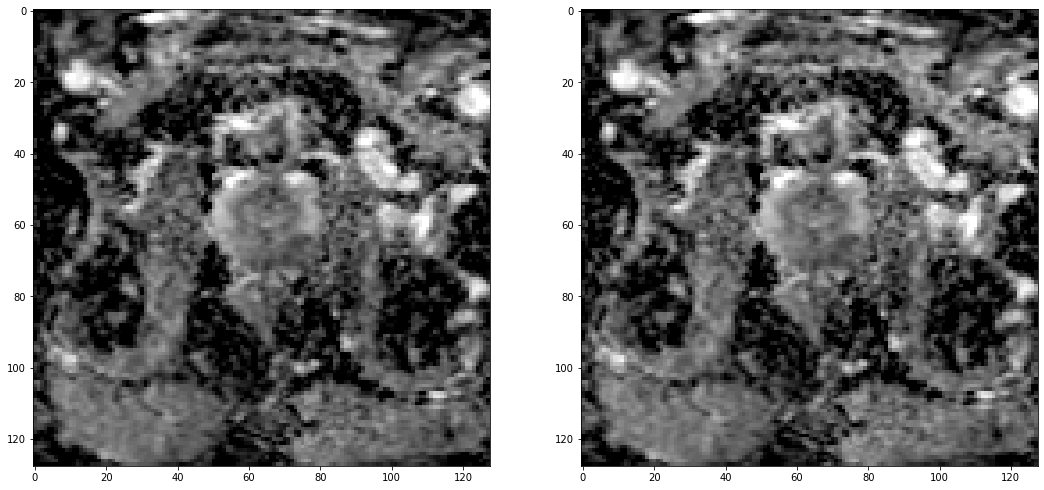

In [49]:
fig, ax = plt.subplots(1,2,figsize=(18,18))
ax[0].imshow(adc_in, cmap='gray',vmin=0.1, vmax = 3)
ax[1].imshow(adc_out, cmap='gray',vmin=0.1,vmax=3)
adc_out.max()

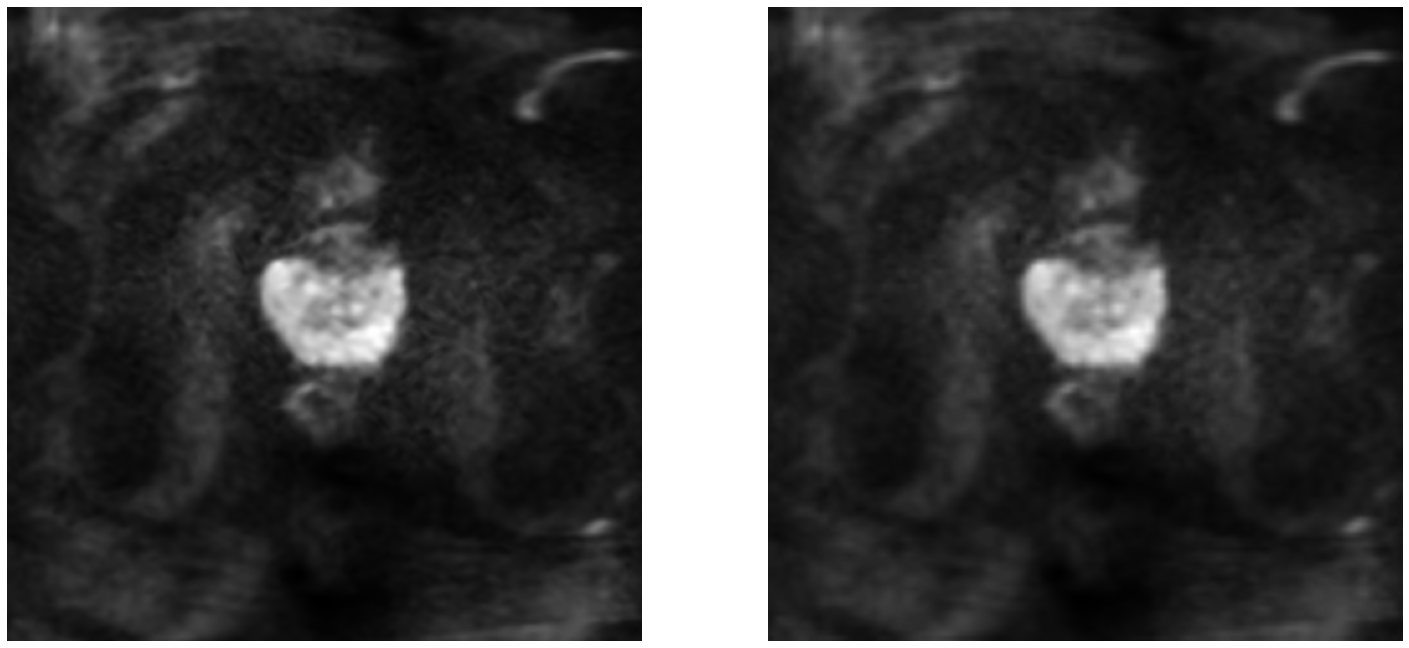

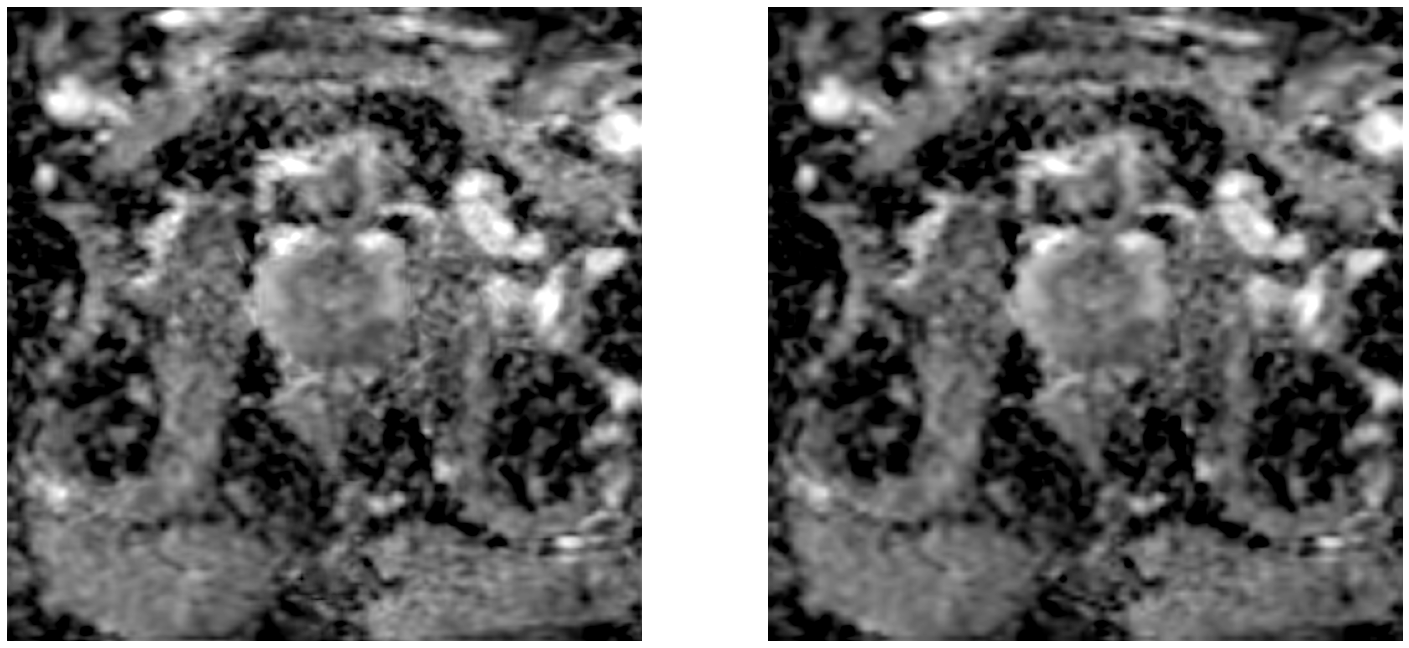

In [50]:
big_size = 512
big_mean = np.zeros((big_size,big_size))
model_input  = get_mgrid(big_size, 2).cuda()
for i in range(case.b3.shape[3]):
    big_mean += img_siren(model_input, i, 1.0/128).cpu().view(big_size,big_size).detach().numpy()
big_mean /= case.b3.shape[3]

fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[0].imshow(big_mean, cmap='gray')
axes[1].imshow(rescale(img,4), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
plt.show()


fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[0].imshow(calc_adc(big_mean, rescale(b0,4), case.b[3]), cmap='gray',vmin=0,vmax=3)
axes[1].imshow(rescale(calc_adc(img, b0, case.b[3]),4), cmap = 'gray',vmin=0,vmax=3)
axes[0].axis('off')
axes[1].axis('off')
plt.show()